# **Brain Tumor MRI Image Classification**    



##### **Project Type**    - Classification
##### **Contribution**    - Individual(Anustup Hazra)

# **Project Summary -**

The Brain Tumor MRI Image Classification project focuses on leveraging deep learning techniques to automatically classify MRI brain scans into different tumor types. Early and accurate identification of brain tumors is critical for treatment planning and patient outcomes. Manual diagnosis by radiologists, although effective, is time-consuming and prone to human error due to image complexity and volume. This project aims to enhance medical diagnostics using AI-powered image classification tools.

The primary goal is to build a high-performance model capable of distinguishing between various brain tumor types using MRI images. The project explores two parallel approaches to model building: a custom-built Convolutional Neural Network (CNN) from scratch and a transfer learning-based model using pretrained architectures like ResNet50, MobileNetV2, InceptionV3, or EfficientNetB0. Both models will be evaluated and compared to identify the most accurate, generalizable, and efficient solution.

The process begins with understanding and analyzing the dataset, which consists of labeled MRI images across multiple tumor categories. Important initial steps include visual exploration of sample images, checking class distribution for imbalance, and ensuring consistent image resolution. Following this, a thorough data preprocessing pipeline is applied to resize images, normalize pixel values, and encode labels appropriately.

To improve model robustness and avoid overfitting, data augmentation techniques such as random rotation, flipping, zooming, and brightness adjustments are implemented during training. The custom CNN is constructed with layers of convolution, pooling, dropout, and batch normalization to extract hierarchical image features. Simultaneously, transfer learning models are loaded with pretrained ImageNet weights, and their classifier heads are replaced to match the tumor classes. Optionally, the top layers are unfrozen for fine-tuning.

Training is conducted with callbacks like EarlyStopping and ModelCheckpoint to monitor validation performance and retain the best model weights. Throughout training, accuracy and loss metrics are tracked and plotted to analyze learning trends.

Post-training, both models are subjected to thorough evaluation using performance metrics such as accuracy, precision, recall, F1-score, and confusion matrix. These evaluations help determine each model’s capability to generalize and handle multi-class predictions. A comparative study is then conducted to assess which approach—custom CNN or transfer learning—delivers superior performance in terms of accuracy and computational efficiency.

The final phase of the project involves deployment using Streamlit, a Python-based web app framework. The interactive app allows users (e.g., radiologists or medical technicians) to upload an MRI image and receive an instant prediction of tumor type along with the model's confidence score. This real-time deployment provides an intuitive interface that makes AI-assisted diagnostics easily accessible.

To ensure clarity and reproducibility, the project includes:

• Clean and modular Python scripts or Jupyter Notebooks,

• Saved model files (.h5),

• A well-documented GitHub repository with README and usage instructions.

This project not only contributes to the medical AI field but also provides hands-on experience in key concepts like data preprocessing, model building, transfer learning, and web deployment. Its practical application in healthcare AI demonstrates how deep learning can be effectively used for real-world problem-solving in radiology.

# **GitHub Link -**

Provide your GitHub Link here.

# **Problem Statement**


Brain tumor diagnosis using MRI scans is a critical yet time-intensive task in medical imaging. Radiologists are required to analyze a large number of scans manually, which may lead to delayed diagnoses and potential human error. This project aims to build an AI-powered image classification system that can automatically classify brain MRI images into different tumor types. The objective is to design, train, and deploy both custom CNN and pretrained transfer learning models, ultimately integrating the best-performing model into a Streamlit web application for real-time tumor classification. This solution is expected to enhance diagnostic speed, accuracy, and accessibility in clinical settings.



# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [1]:
# Import Libraries
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data
import random
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset Loading

In [3]:
# Load Dataset
train_dir = '/content/drive/MyDrive/Labmentix projects/Brain Tumor MRI/Tumour/train'
test_dir = '/content/drive/MyDrive/Labmentix projects/Brain Tumor MRI/Tumour/test'



## 2. ***Data Wrangling***

### Data Wrangling Code

In [4]:
# Load and shuffle the train data
train_paths = []
train_labels = []
for label_name in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label_name)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            train_paths.append(os.path.join(label_path, image))
            train_labels.append(label_name)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label_name in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label_name)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            test_paths.append(os.path.join(label_path, image))
            test_labels.append(label_name)

test_paths, test_labels = shuffle(test_paths, test_labels)


## ***3. Data Vizualization: Understand the relationships between variables***

#### sample images


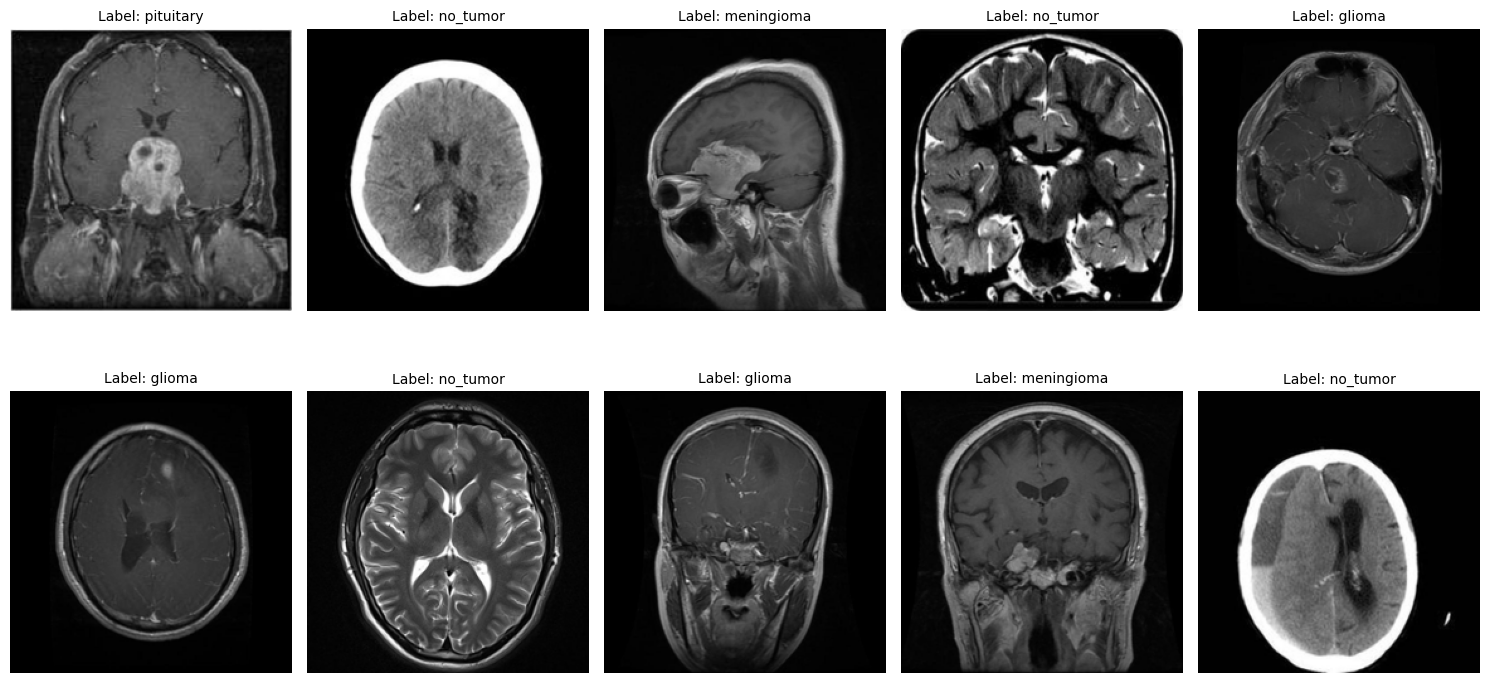

In [5]:
# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

## ***4. Image Preprocessing (Helper Functions)***

In [6]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

## ***5. ML Model Implementation***

### ML Model - 1

In [7]:
# ML Model - 1 Implementation

# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 534s 6s/step - loss: 0.9411 - sparse_categorical_accuracy: 0.6316
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - loss: 0.3690 - sparse_categorical_accuracy: 0.8748
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.2294 - sparse_categorical_accuracy: 0.9293
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.1511 - sparse_categorical_accuracy: 0.9515
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.9549


## **6. Train and Validation Plots**

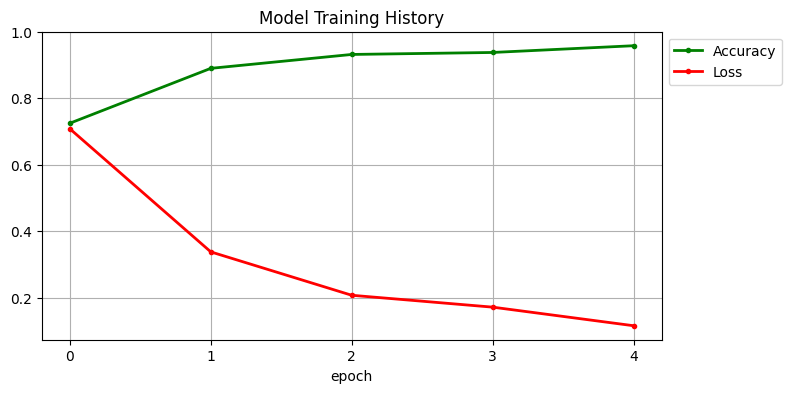

In [17]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## **7.Model Classification Report**

### Prediction on test data

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 603ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.99      0.95        80
           2       0.89      0.86      0.87        63
           3       0.91      0.82      0.86        49
           4       0.95      0.96      0.95        54

    accuracy                           0.91       246
   macro avg       0.91      0.91      0.91       246
weighted avg       0.91      0.91      0.91       246



###Model Confusion Plot

Confusion Matrix:
[[79  1  0  0]
 [ 4 54  3  2]
 [ 3  5 40  1]
 [ 0  1  1 52]]


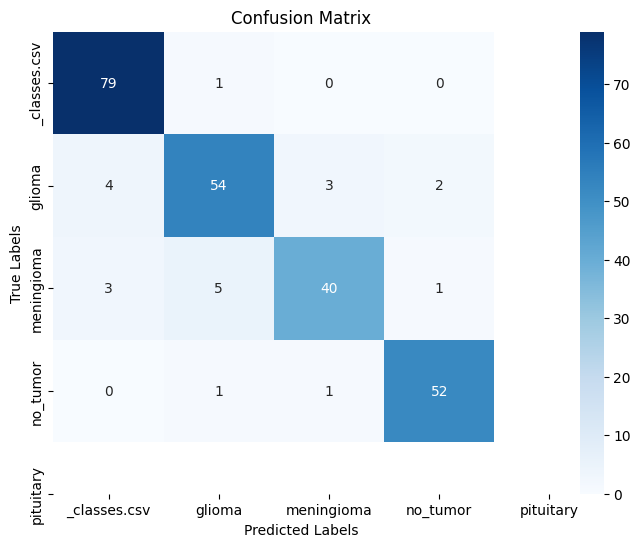

In [19]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###Roc Curve Plot

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


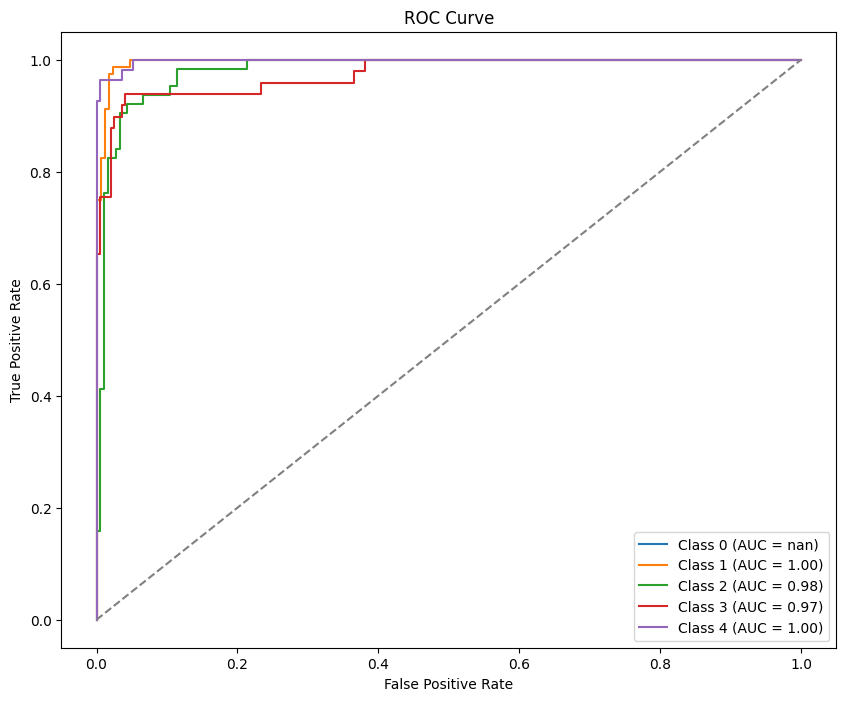

In [20]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

##**8. Future Work**

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [21]:
# Save the File
model.save('model.h5')

### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [22]:
# Load the File and predict unseen data.
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

MRI Tumor Detection System

In [23]:
from keras.preprocessing.image import load_img, img_to_array

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


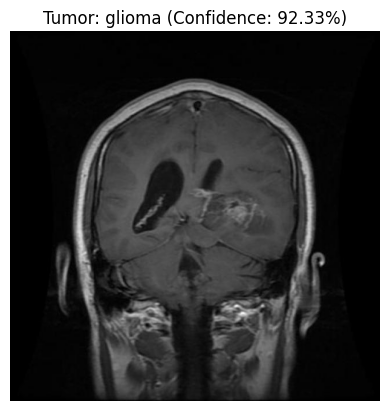

In [34]:
# Example usage
image_path = '/content/drive/MyDrive/Labmentix projects/Brain Tumor MRI/Tumour/test/glioma/Tr-gl_0101_jpg.rf.11f5cfff6b549f258a54d8c0c8fb3921.jpg'
detect_and_display(image_path, model)

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***